This is an attempt to predict stock market prices. Below, I will make the necessary imports.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error

original shape: (2597,)
(2597,)
Notice how X changes
r value
0.9544271550371081
RMSE: 
82.21312309487642


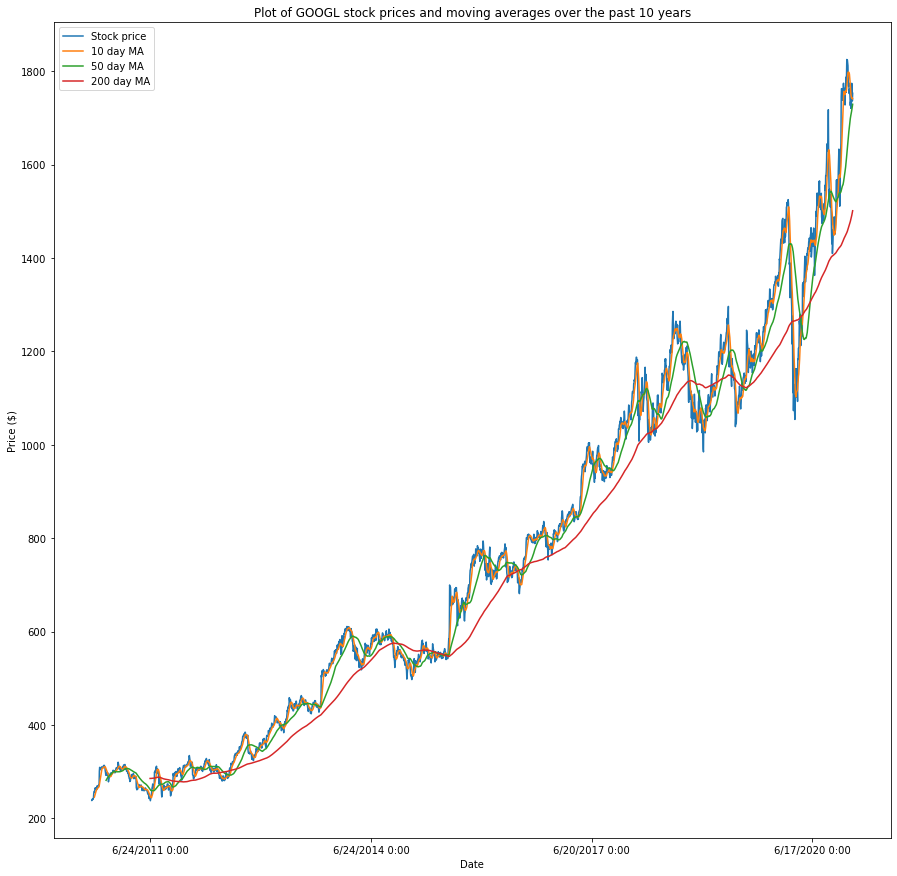

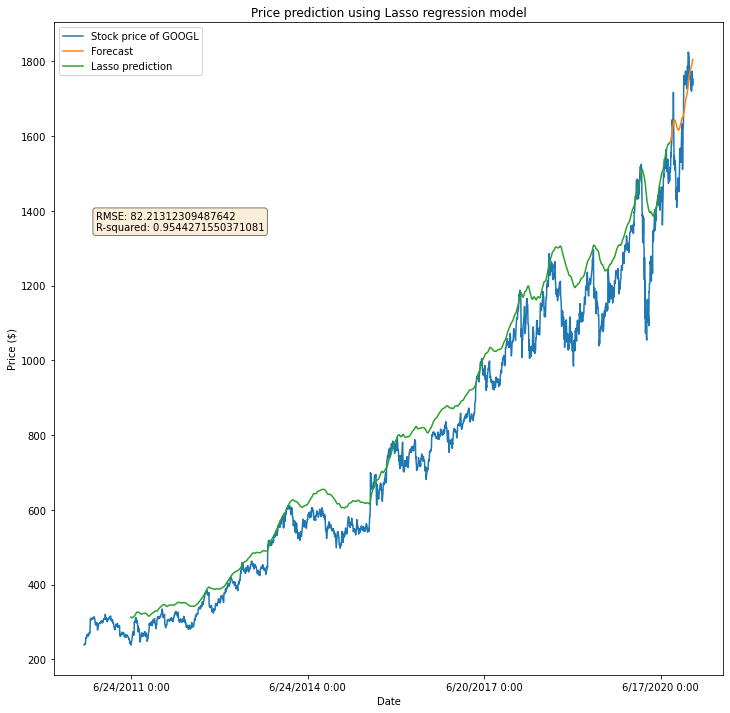

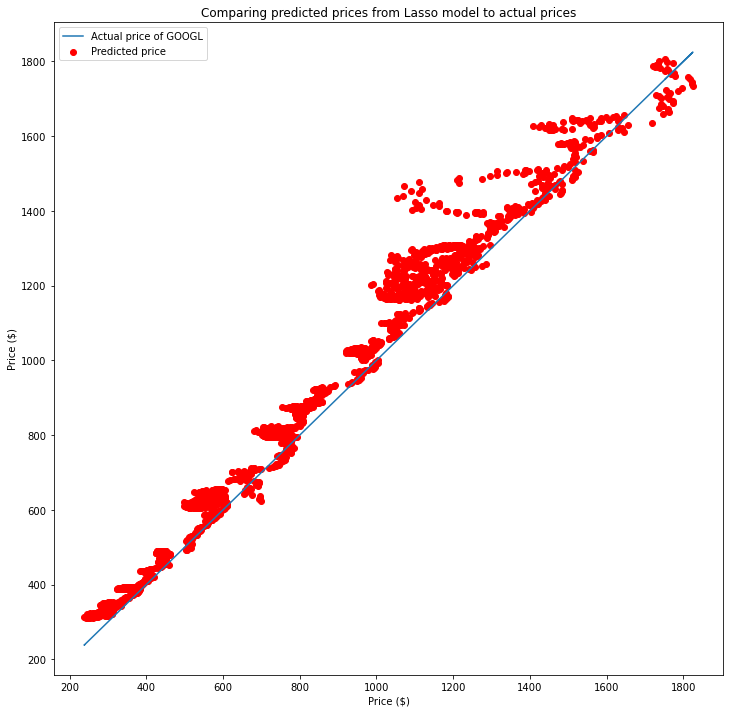

In [8]:
def lasso_prediction(stock, num_days=30):
    df = pd.read_csv('moving_average_plus_returns.csv')
    stock_prices = df[stock]
    _10day_ma = df[stock + '_10day_MA']
    _50day_ma = df[stock+ '_50day_MA']
    _200day_ma = df[stock+ '_200day_MA']
    _5day_mr = df[stock+ '_5day_mvg_return']
    _20day_mr = df[stock+ '_20day_mvg_return']
    _260day_mr = df[stock+ '_260day_mvg_return']
    ### plotting moving averages
    fig, axes = plt.subplots(1,1)
    axes.plot(df['Date'], stock_prices)
    axes.plot(df['Date'], _10day_ma)
    axes.plot(df['Date'], _50day_ma)
    axes.plot(df['Date'], _200day_ma)
    axes.set_title("Plot of " + stock + " stock prices and moving averages over the past 10 years")
    axes.legend(["Stock price", "10 day MA", "50 day MA", "200 day MA"])
    axes.xaxis.set_label_text("Date")
    axes.yaxis.set_label_text("Price ($)")

    axes.set_xticks([200, 953, 1706, 2459]) #adjusts the number of ticks (dates displayed on x axis)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ### end of plotting moving averages


    ###start of applying lasso regression
    print("original shape: {}".format(stock_prices.shape))
    stock_prediction = stock_prices.shift(-num_days)
    print(stock_prediction.shape)
    X = np.stack((_10day_ma[199:], _50day_ma[199:], _200day_ma[199:]), axis=1) #we do this so there are no nan values. index 199 is where 200day_ma starts
    print("Notice how X changes")
    X = X[:-num_days]

    y = stock_prediction[199:] #X and y need to have the same number of rows, so we also start at index 199
    y = y[:-num_days]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    lasso_regression = Lasso()
    lasso_regression.fit(X_train, y_train)
    lasso_regression_score = lasso_regression.score(X_test, y_test)
    print("r value")
    print(lasso_regression_score)

    X_pred = np.stack((_10day_ma[199:], _50day_ma[199:], _200day_ma[199:]), axis=1)
    X_pred = X_pred[-num_days:]
    predict_prediction = lasso_regression.predict(X_pred)
    real_prediction = lasso_regression.predict(np.stack((_10day_ma[199:], _50day_ma[199:], _200day_ma[199:]), axis=1))
    print("RMSE: ")
    rmse = mean_squared_error(y, real_prediction[:-num_days], squared=False)
    print(mean_squared_error(y, real_prediction[:-num_days], squared=False))


    predicted_dates = [] #this is for calculating the predicted dates in the future
    for i in range(num_days):
        date = (datetime.strptime(df['Date'][2596], '%m/%d/%Y %H:%M') + timedelta(days=i + 1)).strftime('%m/%d/%Y %H:%M')
        predicted_dates.append(date)
    predicted_dates = np.asarray(predicted_dates)


    ##plotting the model
    fig, axes = plt.subplots(1,1)
    axes.plot(df['Date'], stock_prices)
    axes.plot(df['Date'][-num_days:], predict_prediction)
    axes.plot(df['Date'][199:-num_days + 1], real_prediction[:-num_days + 1])



    axes.set_title("Price prediction using Lasso regression model")
    axes.legend(["Stock price of " + stock, "Forecast", "Lasso prediction"])
    axes.xaxis.set_label_text("Date")
    axes.yaxis.set_label_text("Price ($)")

    textstr = '\n'.join(("RMSE: {}".format(rmse), "R-squared: {}".format(lasso_regression_score)))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axes.text(50, 1400, textstr, bbox = props, verticalalignment = 'top') #adjust this if the RMSE box is messed up

    axes.set_xticks([200, 953, 1706, 2459]) #adjusts the number of ticks (dates displayed on x axis)
    fig.set_figheight(12)
    fig.set_figwidth(12)

    ####plot to compare the predicted data points to the actual stock prices
    fig2, axes2 = plt.subplots(1,1)
    axes2.plot(stock_prices, stock_prices)
    axes2.scatter(stock_prices[199:],real_prediction,  color="red")
    axes2.set_title("Comparing predicted prices from Lasso model to actual prices")
    axes2.legend(["Actual price of {}".format(stock), "Predicted price"])
    axes2.yaxis.set_label_text("Price ($)")
    axes2.xaxis.set_label_text("Price ($)")
    fig2.set_figheight(12)
    fig2.set_figwidth(12)



#### Here is where you can run the function
lasso_prediction('GOOGL', 100) #pass in the stock abreviation and number of days to predict. The default number of days is 30